# 🏞 합성곱 신경망

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

이 노트북에서는 CIFAR 데이터셋에서 합성곱 신경망(CNN)을 훈련하는 데 필요한 단계를 소개합니다.

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2024-01-29 14:32:34--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-01-29 14:32:34 (36.7 MB/s) - ‘utils.py’ saved [771/771]



In [2]:
import numpy as np

from tensorflow.keras import layers, models, optimizers, utils, datasets
from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [3]:
NUM_CLASSES = 20

## 1. 데이터 준비 <a name="prepare"></a>

### 1) 데이터 불러오기 및 구조 확인
- 모자의 종류를 분류하는 [Headgear 20 classes-Image Classification](https://www.kaggle.com/datasets/gpiosenka/headgear-image-classification?resource=download) 데이터셋을 구글 드라이브에서 불러오도록 합니다.

In [7]:
# drive 모듈 이용하여 드라이브 마운트 하기
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# 연동이 되었는지 확인
import os
os.listdir('/content/gdrive/MyDrive/Colab Notebooks/study/headgear')

['headgear-20-(224 X 224)- 98.99.h5',
 'headgear.csv.csv',
 'valid',
 'train',
 'test']

- 데이터 경로 설정

In [9]:
train_dir = '/content/gdrive/MyDrive/Colab Notebooks/study/headgear/train'
test_dir = '/content/gdrive/MyDrive/Colab Notebooks/study/headgear/test'
valid_dir = '/content/gdrive/MyDrive/Colab Notebooks/study/headgear/valid'

In [11]:
os.listdir(train_dir)

['ZUCCHETTO',
 'TOP HAT',
 'SOUTHWESTER',
 'SOMBERO',
 'PORK PIE',
 'PITH HELMET',
 'MOTARBOARD',
 'MILITARY HELMET',
 'HARD HAT',
 'GARRISON CAP',
 'FEZ',
 'FEDORA',
 'DEERSTALKER',
 'BOWLER',
 'BOATER',
 'BICORNE',
 'BERET',
 'BASEBALL CAP',
 'ASCOT CAP',
 'FOOTBALL HELMET']

In [19]:
# 이미지 데이터셋 불러오기
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred', # 자동으로 레이블 생성
    label_mode='categorical', # 분류 문제
    color_mode='rgb',
    image_size=(224, 224), # 이미지 크기
    batch_size=32,
    class_names=None
)

Found 3413 files belonging to 20 classes.


In [17]:
CLASS_NAMES = train_dataset.class_names
print(CLASS_NAMES)

['ASCOT CAP', 'BASEBALL CAP', 'BERET', 'BICORNE', 'BOATER', 'BOWLER', 'DEERSTALKER', 'FEDORA', 'FEZ', 'FOOTBALL HELMET', 'GARRISON CAP', 'HARD HAT', 'MILITARY HELMET', 'MOTARBOARD', 'PITH HELMET', 'PORK PIE', 'SOMBERO', 'SOUTHWESTER', 'TOP HAT', 'ZUCCHETTO']


In [18]:
# 검증 데이터셋
valid_dataset = image_dataset_from_directory(
    valid_dir,
    labels='inferred', # 자동으로 레이블 생성
    label_mode='categorical', # 분류 문제
    color_mode='rgb',
    image_size=(224, 224), # 이미지 크기
    batch_size=32,
    class_names=None
)

Found 5 files belonging to 20 classes.


In [37]:
test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', # 자동으로 레이블 생성
    label_mode='categorical', # 분류 문제
    color_mode='rgb',
    image_size=(224, 224), # 이미지 크기
    batch_size=32,
    class_names=None
)

Found 100 files belonging to 20 classes.


- 데이터 샘플 확인

(32, 224, 224, 3) (32, 20)


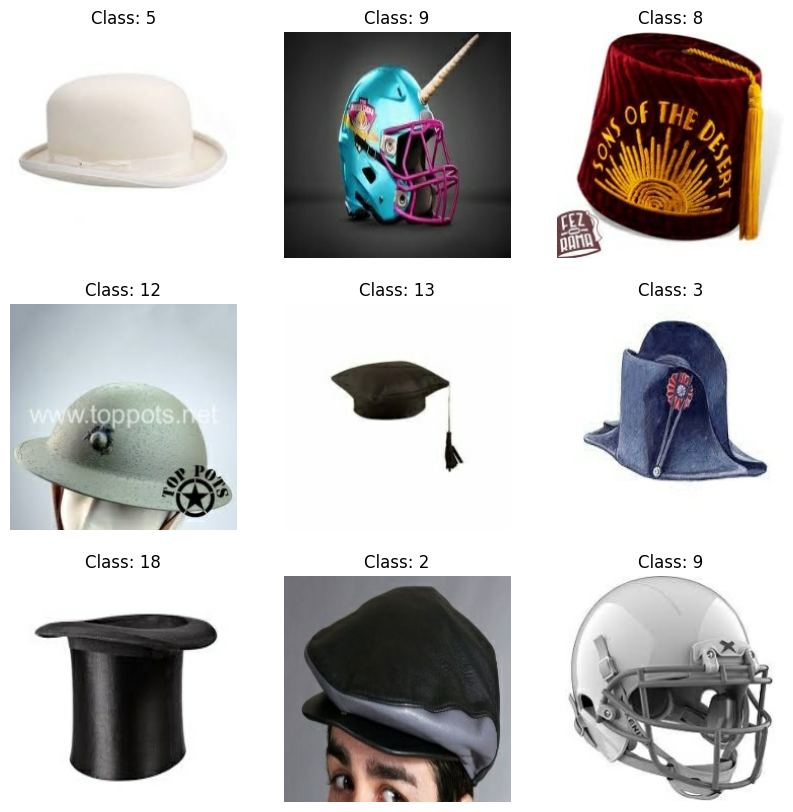

In [25]:
import matplotlib.pyplot as plt

for data, label in train_dataset.take(1):
  print(data.shape, label.shape)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i].numpy().astype('uint8'))
    plt.title(f'Class: {tf.argmax(label[i])}')
    plt.axis("off")
  plt.show()

### 2) 이미지 전처리

In [26]:
# 범위 [0, 255]에서 [0., 1.]로 정규화하는 함수
def normalize_image(x, y):
  return x / 255.0, y

In [27]:
# 데이터셋에 적용
train_dataset = train_dataset.map(normalize_image)
valid_dataset = valid_dataset.map(normalize_image)

In [38]:
test_dataset = test_dataset.map(normalize_image)

In [29]:
# 확인
for data, label in train_dataset.take(1):
  data_numpy = data.numpy()
  print(np.min(data_numpy), np.max(data_numpy))

0.0 1.0


## 2. 모델 만들기

In [47]:
input_layer = layers.Input((224, 224, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_10 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 224, 224, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_11 (Ba  (None, 112, 112, 32)      128       
 tchNormalization)                                         

## 3. 모델 훈련

In [48]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']
)

In [49]:
model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

Epoch 1/10
107/107 [==============================] - 17s 119ms/step - loss: 2.4584 - accuracy: 0.2822 - val_loss: 3.0571 - val_accuracy: 0.0700
Epoch 2/10
107/107 [==============================] - 14s 124ms/step - loss: 1.6637 - accuracy: 0.5989 - val_loss: 2.9360 - val_accuracy: 0.1000
Epoch 3/10
107/107 [==============================] - 13s 118ms/step - loss: 1.0860 - accuracy: 0.8623 - val_loss: 2.6740 - val_accuracy: 0.2700
Epoch 4/10
107/107 [==============================] - 13s 115ms/step - loss: 0.7719 - accuracy: 0.9625 - val_loss: 2.3970 - val_accuracy: 0.4600
Epoch 5/10
107/107 [==============================] - 16s 140ms/step - loss: 0.6020 - accuracy: 0.9854 - val_loss: 2.1040 - val_accuracy: 0.5400
Epoch 6/10
107/107 [==============================] - 13s 113ms/step - loss: 0.4974 - accuracy: 0.9930 - val_loss: 1.9567 - val_accuracy: 0.5200
Epoch 7/10
107/107 [==============================] - 13s 112ms/step - loss: 0.4299 - accuracy: 0.9962 - val_loss: 1.9017 - val_ac

## 4. 평가

In [50]:
model.evaluate(valid_dataset)

1/1 [==============================] - 0s 93ms/step - loss: 1.6292 - accuracy: 0.6000


[1.6291548013687134, 0.6000000238418579]

In [53]:
model.evaluate(test_dataset)

4/4 [==============================] - 1s 32ms/step - loss: 1.8322 - accuracy: 0.5300


[1.8322070837020874, 0.5299999713897705]

### 테스트 해보기
인터넷에서 이미지 url을 읽어와 제대로 분류하는지 테스트 진행

In [118]:
import os
import subprocess

url = 'http://www.kukjesafety.co.kr/data/editor/2009/aaeed3354b540e8d4e5792c59e92bc22_1601017724_5661.jpg'
answer = 'HARD HAT'

try:
  if url == "" or url == None:
    raise ValueError('url을 입력하세요.')
  else:
    test_path = tf.keras.utils.get_file(
        fname="test1."+url.split('.')[-1],
        origin=url
    )

    test_img = tf.keras.utils.load_img(
        test_path,
        grayscale=False,
        target_size=(224, 224)
    )
    test_img = tf.keras.utils.img_to_array(test_img)
    test_img /= 255.0
    test_img = np.array([test_img])

    prediction = model.predict(test_img)
    pred_idx = np.argmax(prediction, axis=1)[0]
    pred_class = CLASS_NAMES[pred_idx]
    print(f'Pred : {pred_class}')
    print(f'Act : {answer}')

except Exception as e:
  print(e)

1/1 [==============================] - 0s 70ms/step
Pred : HARD HAT
Act : HARD HAT


시각화

(-0.5, 223.5, 223.5, -0.5)

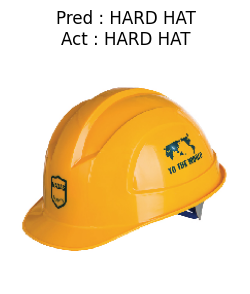

In [121]:
def denormalize(x):
  return (x * (2**8 - 1)).astype('uint8')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(denormalize(test_img[0]))
ax.set_title(f'Pred : {pred_class}\nAct : {answer}')
ax.axis('off')